In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()



'/device:GPU:0'

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.morphology import medial_axis, skeletonize

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/MITACS_22/SPAC_FINAL.zip -d /content/colab_local_split  > /dev/null.

In [ ]:
# https://youtu.be/XhxF2JV6PcI
# Building Unet by dividing encoder and decoder into blocks

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  #Binary (can be multiclass)

    model = Model(inputs, outputs, name="U-Net")
    return model


In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import multiprocessing


In [ ]:
#New generator with rotation and shear where interpolation that comes with rotation and shear are thresholded in masks. 
#This gives a binary mask rather than a mask with interpolated values. 
seed=24
batch_size= 4
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rescale = 1/255.,
                                                  
                      width_shift_range=0.0,
                      height_shift_range=0.0,
                      shear_range=0.0,
                      zoom_range=0.2,
                      
                      fill_mode = 'nearest'
                      )

mask_data_gen_args = dict(rescale = 1/255.,  #Original pixel values are 0 and 255. So rescaling to 0 to 1
                                              
                      width_shift_range=0.0,
                      height_shift_range=0.0,
                      shear_range=0.0,
                      zoom_range=0.2,
                      
                      fill_mode = 'nearest',
                      
                      preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again. 

valid_data_gen_args = dict(rescale = 1/255.)


In [ ]:

#If You need to resize images then add this to the flow_from_directory parameters 
#target_size=(150, 150), #Or whatever the size is for your network

#image_data_generator = ImageDataGenerator(**img_data_gen_args) # Use Augmentation
image_data_generator = ImageDataGenerator(rescale = 1/255.)
                                         
image_generator = image_data_generator.flow_from_directory("/content/colab_local_split/SPAC_FINAL/train_images", 
                                                           seed=seed, 
                                                           target_size=(256, 256),
                                                           batch_size=batch_size,
                                                           color_mode = 'grayscale',
                                                           class_mode=None)  #Very important to set this otherwise it returns multiple numpy arrays 
                                                                            #thinking class mode is binary.

#mask_data_generator = ImageDataGenerator(**mask_data_gen_args) 

mask_generator = image_data_generator.flow_from_directory("/content/colab_local_split/SPAC_FINAL/train_masks", 
                                                         seed=seed, 
                                                         target_size=(256, 256),
                                                         batch_size=batch_size,
                                                         color_mode = 'grayscale',   #Read masks in grayscale
                                                         class_mode=None)


#valid_img_data_generator = ImageDataGenerator(**valid_data_gen_args)
#valid_mask_data_generator = ImageDataGenerator(**valid_data_gen_args)

valid_img_generator = image_data_generator.flow_from_directory("/content/colab_local_split/SPAC_FINAL/val_images", 
                                                               seed=seed, 
                                                               batch_size=batch_size,
                                                               target_size=(256, 256),
                                                               color_mode = 'grayscale', 
                                                               class_mode=None) #Default batch size 32, if not specified here
                                                          
valid_mask_generator = image_data_generator.flow_from_directory("/content/colab_local_split/SPAC_FINAL/val_masks", 
                                                               seed=seed, 
                                                               batch_size=batch_size, 
                                                               target_size=(256, 256),
                                                               color_mode = 'grayscale',   #Read masks in grayscale
                                                               class_mode=None)  #Default batch size 32, if not specified here


train_generator = zip(image_generator, mask_generator)
val_generator = zip(valid_img_generator, valid_mask_generator)

Found 181 images belonging to 1 classes.
Found 181 images belonging to 1 classes.
Found 14 images belonging to 1 classes.
Found 14 images belonging to 1 classes.


0


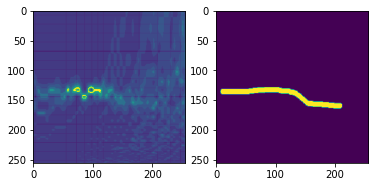

1


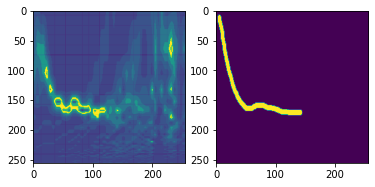

2


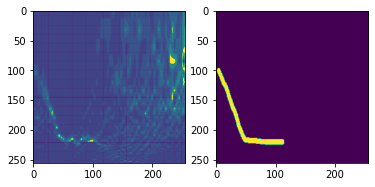

3


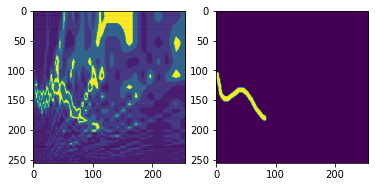

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
x = image_generator.next()
y = mask_generator.next()
for i in range(0,4):
    print(i)    
    image = x[i]
    mask = y[i]
    #image_name = '/content/Augmented_Images/image_'+str(i)+'.jpg';
    #mask_name = '/content/Augmented_Images/mask_'+str(i)+'.jpg';
    #plt.imsave(image_name,image)
    #plt.imsave(mask_name,mask[:,:,0],cmap='gray')
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0])
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    #plt.subplot(1,3,3)
    #plt.imshow(image[:,:,0])
    #plt.imshow(mask[:,:,0], alpha = 0.5)
    plt.show()

In [ ]:
#!zip -r /content/Augmented_Images_zipped.zip /content/Augmented_Images

In [ ]:
#####################################################################
#Define the model. Experiment with various loss functions and accuracy metrics
# pip install focal-loss 

#######################################


#Jaccard distance loss mimics IoU. 
from keras import backend as K
def jaccard_distance_loss(y_true, y_pred, smooth=100):
    intersection = K.sum(K.sum(K.abs(y_true * y_pred), axis=-1))
    sum_ = K.sum(K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

#Dice metric can be a great metric to track accuracy of semantic segmentation.
def dice_metric(y_pred, y_true):
    intersection = K.sum(K.sum(K.abs(y_true * y_pred), axis=-1))
    union = K.sum(K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1))
    # if y_pred.sum() == 0 and y_pred.sum() == 0:
    #     return 1.0

    return 2*intersection / union



IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]


input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = build_unet(input_shape)

In [ ]:
#STANDARD BINARY CROSS ENTROPY AS LOSS AND ACCURACY AS METRIC
#model.compile(optimizer=Adam(lr = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])

#JACCARD LOSS AND DICE METRIC 
#model.compile(optimizer=Adam(lr = 1e-3), loss=jaccard_distance_loss, metrics=[dice_metric])

#FOCAL LOSS AND DICE METRIC
#Focal loss helps focus more on tough to segment classes.
!pip install focal-loss
from focal_loss import BinaryFocalLoss

model.compile(optimizer=Adam(lr = 1e-3), loss=BinaryFocalLoss(gamma=2), metrics=[dice_metric])



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# **Using Segmentation Models Library**

In [ ]:
!pip install segmentation_models
import segmentation_models as sm
sm.set_framework('tf.keras')

sm.framework()
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.9 MB/s 
Segmentation Models: using `keras` framework.


In [ ]:
from segmentation_models import Unet

# define number of channels
#N = X_train.shape[-1]

# define model
model = Unet(backbone_name='resnet34', encoder_weights=None, input_shape=(None, None, 1))
model.compile('Adam', loss=sm.losses.BinaryFocalLoss(gamma=2.0), metrics=[dice_metric])
#model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
#model.load_weights('/content/drive/MyDrive/MITACS_22/Notebooks/saved_models/Data_generator_11.hdf5')



In [ ]:
base_model = Unet(backbone_name='resnet34', encoder_weights='imagenet')

inp = Input(shape=(None, None, 1))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model(l1)

model = Model(inp, out, name=base_model.name)
model.compile('Adam', loss=sm.losses.BinaryFocalLoss(gamma=2.0), metrics=[dice_metric])
#model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

85532672/85521592 [==============================] - 2s 0us/step


In [ ]:
num_train_imgs = len(os.listdir('/content/colab_local_split/SPAC_FINAL/train_images/images'))

steps_per_epoch = num_train_imgs //batch_size

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto',
                                            baseline=None, restore_best_weights=False)

model.load_weights('/content/drive/MyDrive/MITACS_22/Notebooks/saved_models/SPAC_unet_transfer_5.hdf5')



history = model.fit_generator(train_generator, validation_data=val_generator, 
                    steps_per_epoch=steps_per_epoch,
                    max_queue_size=16, 
                    workers=8,
                    use_multiprocessing=True,
                    verbose = 1,
                    validation_steps=steps_per_epoch, epochs=10, callbacks=[callback])



model.save('/content/drive/MyDrive/MITACS_22/Notebooks/saved_models/SPAC_unet_transfer_6.hdf5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
45/45 [==============================] - 25s 150ms/step - loss: 0.0021 - dice_metric: 0.4614 - val_loss: 0.0067 - val_dice_metric: 0.3204
Epoch 2/10
45/45 [==============================] - 5s 104ms/step - loss: 0.0020 - dice_metric: 0.4070 - val_loss: 0.0068 - val_dice_metric: 0.3108
Epoch 3/10
45/45 [==============================] - 5s 110ms/step - loss: 0.0019 - dice_metric: 0.4400 - val_loss: 0.0073 - val_dice_metric: 0.3218
Epoch 4/10
45/45 [==============================] - 6s 124ms/step - loss: 0.0020 - dice_metric: 0.4294 - val_loss: 0.0063 - val_dice_metric: 0.3118
Epoch 5/10
45/45 [==============================] - 5s 107ms/step - loss: 0.0018 - dice_metric: 0.4648 - val_loss: 0.0070 - val_dice_metric: 0.3409
Epoch 6/10
45/45 [==============================] - 5s 108ms/step - loss: 0.0019 - dice_metric: 0.4871 - val_loss: 0.0070 - val_dice_metric: 0.3425
Epoch 7/10
45/45 [==============================] - 6s 125ms/step - loss: 0.0016 - dice_metric: 0.5149 - val_lo

In [ ]:
import gc
gc.collect()

140

In [ ]:
history = model.fit_generator(train_generator, validation_data=val_generator, 
                    steps_per_epoch=steps_per_epoch,
                    max_queue_size=16, 
                    workers=8,
                    use_multiprocessing=True,
                    verbose = 1,
                    validation_steps=steps_per_epoch, epochs=30, callbacks=[callback])

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


45/45 [==============================] - 6s 129ms/step - loss: 0.0013 - dice_metric: 0.5598 - val_loss: 0.0080 - val_dice_metric: 0.3644
Epoch 2/30
45/45 [==============================] - 6s 122ms/step - loss: 0.0012 - dice_metric: 0.5707 - val_loss: 0.0089 - val_dice_metric: 0.3831
Epoch 3/30
45/45 [==============================] - 6s 127ms/step - loss: 0.0011 - dice_metric: 0.5999 - val_loss: 0.0087 - val_dice_metric: 0.3963
Epoch 4/30
45/45 [==============================] - 5s 110ms/step - loss: 9.9859e-04 - dice_metric: 0.6133 - val_loss: 0.0093 - val_dice_metric: 0.3935
Epoch 5/30
45/45 [==============================] - 5s 111ms/step - loss: 0.0011 - dice_metric: 0.6683 - val_loss: 0.0099 - val_dice_metric: 0.4236
Epoch 6/30
45/45 [==============================] - 5s 112ms/step - loss: 0.0011 - dice_metric: 0.6449 - val_loss: 0.0102 - val_dice_metric: 0.4216


In [ ]:
model.save('/content/drive/MyDrive/MITACS_22/Notebooks/saved_models/SPAC_unet_transfer_1.hdf5')

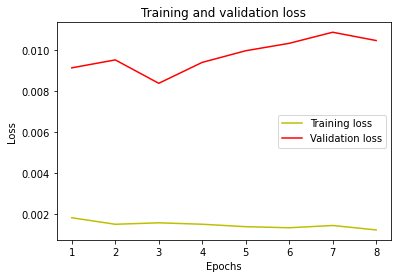

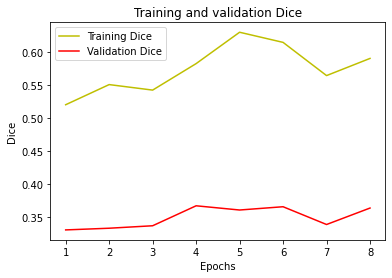

In [ ]:

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['dice_metric']
#acc = history.history['accuracy']
val_acc = history.history['val_dice_metric']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Dice')
plt.plot(epochs, val_acc, 'r', label='Validation Dice')
plt.title('Training and validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

In [ ]:
##############################################################
#Test the model on images we held out for testing.
#We can use the generator again for predictions. 
#Remember that this is not test time augmentation. This is only using augmentaton
#to load images from the drive, perfome augmentation and predict. 
# TTA means predicting on augmenting images and then combining predictions for better
#accuracy. 

#model = tf.keras.models.load_model("/content/drive/MyDrive/MITACS_22/Notebooks/saved_models/Complex_images_model_weights_sm_3.hdf5", compile=False)
#model = tf.keras.models.load_model("/content/drive/MyDrive/MITACS_22/Notebooks/saved_models/Data_generator_13.hdf5", compile=False)
model = tf.keras.models.load_model("/content/drive/MyDrive/MITACS_22/Notebooks/saved_models/SPAC_unet_transfer_6.hdf5", compile=False)
#model = tf.keras.models.load_model("/content/drive/MyDrive/MITACS_22/Notebooks/saved_models/sm_model_full_training_data_4.hdf5", compile=False)


In [ ]:
import random
seed = random.randint(0, 100)

image_data_generator = ImageDataGenerator(rescale = 1/255.)
test_img_generator = image_data_generator.flow_from_directory("/content/colab_local_split/SPAC_FINAL/test_images", 
                                                              seed=seed, 
                                                              batch_size=32, 
                                                              target_size=(256, 256),
                                                              color_mode = 'grayscale',
                                                              class_mode=None) #Default batch size 32, if not specified here

test_mask_generator = image_data_generator.flow_from_directory("/content/colab_local_split/SPAC_FINAL/test_masks", 
                                                              seed=seed, 
                                                              batch_size=32, 
                                                              target_size=(256, 256),
                                                              color_mode = 'grayscale',   #Read masks in grayscale
                                                              class_mode=None)  #Default batch size 32, if not specified here

a = test_img_generator.next()
b = test_mask_generator.next()

### Testing on a few test images
"""
for i in range(0,5):
    image = a[i]
    mask = b[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

"""

Found 13 images belonging to 1 classes.
Found 13 images belonging to 1 classes.


"\nfor i in range(0,5):\n    image = a[i]\n    mask = b[i]\n    plt.subplot(1,2,1)\n    plt.imshow(image[:,:,0], cmap='gray')\n    plt.subplot(1,2,2)\n    plt.imshow(mask[:,:,0])\n    plt.show()\n\n"

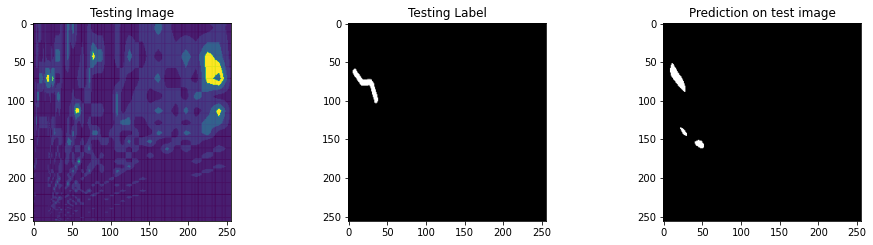

In [ ]:
import random
test_img_number = random.randint(0, a.shape[0]-1)
test_img = a[test_img_number]
ground_truth=b[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.3).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

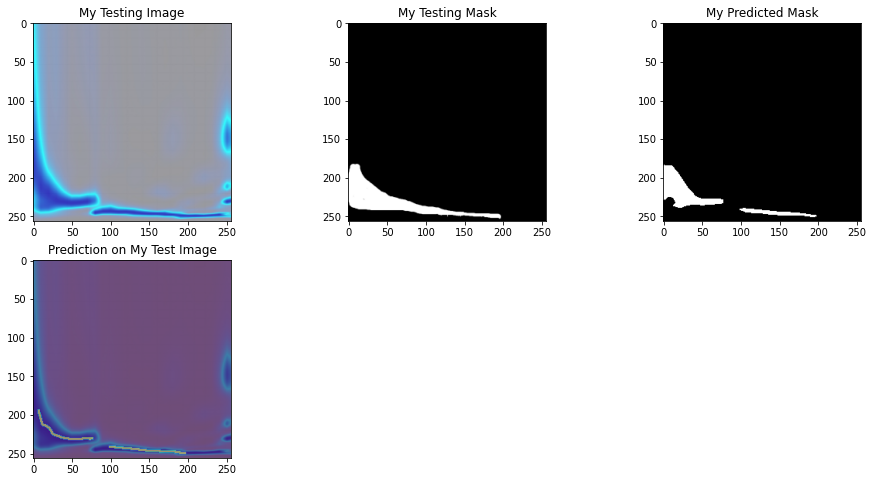

In [ ]:
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
img_name = 'SUR009_fin.jpg' #18010

#load the image
my_image = load_img('/content/colab_local_split/Earth_Mitacs_split/test_images/Earth_Mitacs/' + img_name ,color_mode="grayscale", target_size=(256, 256))
my_mask = load_img('/content/colab_local_split/Earth_Mitacs_split/test_masks/Earth_Mitacs_masks/'+ img_name,color_mode="grayscale", target_size=(256, 256))
test_img = cv2.imread('/content/colab_local_split/Earth_Mitacs_split/test_images/Earth_Mitacs/' + img_name)
resized = cv2.resize(test_img, (256,256), interpolation = cv2.INTER_AREA)

test_mask = cv2.imread('/content/colab_local_split/Earth_Mitacs_split/test_masks/Earth_Mitacs_masks/' + img_name)
resized_mask = cv2.resize(test_mask, (256,256), interpolation = cv2.INTER_AREA)

#preprocess the image
my_image = img_to_array(my_image)/255
my_image_input=np.expand_dims(my_image, 0)

my_mask = img_to_array(my_mask)

#make the prediction
my_prediction = (model.predict(my_image_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.imsave('image.png',my_prediction)

# Find medial axis
#skeleton = medial_axis(my_prediction).astype(np.uint8)
#skeleton = skeletonize(my_prediction)
skeleton = skeletonize(my_prediction, method='lee')
kernel = np.ones((3,3),np.uint8)
skeleton_thick = cv2.dilate(np.float32(skeleton),kernel,iterations = 1)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('My Testing Image')
plt.imshow(resized, cmap='gray')
plt.subplot(232)
plt.title('My Testing Mask')
plt.imshow(resized_mask, cmap='gray')
plt.subplot(233)
plt.title('My Predicted Mask')
plt.imshow(my_prediction, cmap='gray')
plt.subplot(234)
plt.title('Prediction on My Test Image')
plt.imshow(resized)
plt.imshow(skeleton_thick, alpha = 0.5)


plt.show()

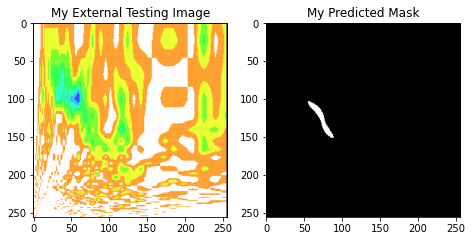

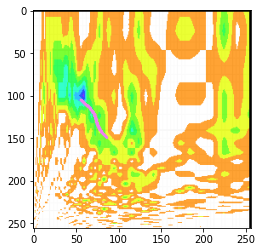

In [ ]:
ext_img_name = '/content/test_41.png'
ext_orig = '/content/test_41x.png'

from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
test_image_ext = load_img(ext_img_name,color_mode="grayscale", target_size=(256, 256))
test_image_ext = img_to_array(test_image_ext)/255
test_image_ext_input=np.expand_dims(test_image_ext, 0)

#ext_test_img = cv2.imread(ext_img_name)
#resized_ext = cv2.resize(ext_test_img, (256,256), interpolation = cv2.INTER_AREA)

v1 = load_img(ext_orig,target_size=(256, 256))


test_image_ext_prediction = (model.predict(test_image_ext_input)[0,:,:,0] > 0.45).astype(np.uint8)

skeleton = skeletonize(test_image_ext_prediction, method='lee')
kernel = np.ones((3,3),np.uint8)
skeleton_thick = cv2.dilate(np.float32(skeleton),kernel,iterations = 1)

plt.figure(figsize=(16, 8))
plt.subplot(141)
plt.title('My External Testing Image', )
plt.imshow(v1)
plt.subplot(142)
plt.title('My Predicted Mask')
plt.imshow(test_image_ext_prediction, cmap='gray')
#plt.subplot(233)
#plt.title('Prediction on My Test Image')
#plt.imshow(v1)
#plt.imshow(skeleton_thick, alpha = 0.3)

fig, ax = plt.subplots()
ax.imshow(v1)
ax.contour(skeleton, colors='violet')
plt.savefig('final_fig.jpg')

In [ ]:
coords = np.column_stack(np.where(skeleton>0)) # Co-ordinates of the dispersion curve


In [ ]:
y_min = 100
y_max = 1200

x_min = 0
x_max = 60


scale_factor_y = ((y_max - y_min)/256)
scale_factor_x = ((x_max - x_min)/256)


vel=1/((np.abs((coords[:,0])-256))*scale_factor_y + y_min)

# If frequency is on logarithmic scale:

#https://stackoverflow.com/questions/19472747/convert-linear-scale-to-logarithmic

x1 = 0
x2 = 256
b = (np.log(x_min/x_max))/(x1-x2)
a = x_min/(np.exp(b*x1))
#freq = a*np.exp(b*coords[:,1])                # Uncomment this line if frequency is on logarithmic scale

freq = coords[:,1] * scale_factor_x + x_min                     # Uncomment this line if frequency is on linear scale

f_v = list(zip(freq,vel))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
f_v

[(13.125, 0.0013354199269692228),
 (13.359375, 0.0013431269674711438),
 (13.59375, 0.0013509234828496042),
 (13.828125, 0.0013588110403397028),
 (14.0625, 0.0013667912439935931),
 (14.296875, 0.0013748657357679913),
 (14.53125, 0.0013830361966504592),
 (14.765625, 0.001391304347826087),
 (15.0, 0.001391304347826087),
 (15.234375, 0.0013996719518862767),
 (15.46875, 0.0014081408140814082),
 (15.703125, 0.0014167127836192583),
 (15.703125, 0.0014253897550111359),
 (15.9375, 0.0014341736694677872),
 (16.171875, 0.001443066516347238),
 (16.40625, 0.001452070334656835),
 (16.40625, 0.0014611872146118722),
 (16.640625, 0.0014704192992533026),
 (16.875, 0.0014797687861271677),
 (16.875, 0.001489237929028505),
 (16.875, 0.0014988290398126464),
 (17.109375, 0.0015085444902769593),
 (17.109375, 0.0015183867141162514),
 (17.109375, 0.0015283582089552238),
 (17.34375, 0.0015384615384615385),
 (17.34375, 0.0015486993345432546),
 (17.34375, 0.001559074299634592),
 (17.34375, 0.0015695892090741876),


In [ ]:
#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())

InvalidArgumentError: ignored

In [ ]:



#Calculate IoU and average
 
import pandas as pd

IoU_values = []
for img in range(0, a.shape[0]):
    temp_img = a[img]
    ground_truth=b[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)
    


df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)    
    

InvalidArgumentError: ignored